# Understanding Blackwell's Customers

The fictitious electronics store Blackwell Electronics wanted to know how the demographics of their customers affected how much money they spent in each transaction. They also wanted to know which demographics had strong correlations with one another. They asked specifically about the correlation between age and region, and age and whether a customer made an online or in-store purchase.

## The Data

The data included the following demographic information for each transaction:
* age
* number of items bought
* the amount they spent
* the region the transaction took place in
* whether the purchase took place in store or online

I'll start by importing all the necessary packages and loading the data.

In [1]:
#Importing important programs
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interactive

#Classification algorithms
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

#Regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

D:\Users\jryba\anaconda3\envs\DataAnalyticsCourse\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#loading the data
data = pd.read_csv('Demographic_Data2.csv')
data = data.drop(columns='Unnamed: 0')
data.describe()

,in-store,age,items,amount,region,decade,amount_bins
count,79979.000000,79979.000000,79979.000000,79979.000000,79979.000000,79979.000000,79979.000000
mean,0.500006,45.758512,4.505133,835.825727,2.674915,40.312082,1079.383338
std,0.500003,15.715158,2.061250,721.263650,1.126642,16.118594,712.303986
min,0.000000,18.000000,1.000000,5.004700,1.000000,10.000000,500.000000
25%,0.000000,33.000000,3.000000,285.120000,2.000000,30.000000,500.000000
50%,1.000000,45.000000,4.000000,582.140000,3.000000,40.000000,1000.000000
75%,1.000000,56.000000,6.000000,1233.400000,4.000000,50.000000,1500.000000
max,1.000000,85.000000,8.000000,3000.000000,4.000000,80.000000,3000.000000


After cleaning, the data has just under 80,000 transactions. I opted to exclude any duplicate rows or rows that have missing information instead of replacing the null values. 

To make the machine learning algorithms more streamlined, I converted all the non-numeric values to numeric. I also added a column of ages sorted into bins by decade and a column with the amounts sorted by increments of 500 dollars.  This will help a classification algorithm when determining the customers' ages and amounts spent. With fewer options to choose from, the algorithm will be much more accurate.

## Exploratory Analysis

I'm comparing the correlations between the variables. This is to check if there is anything of business value for Blackwell and to give me an idea of where to start for the machine learning algorithms.

<AxesSubplot:>

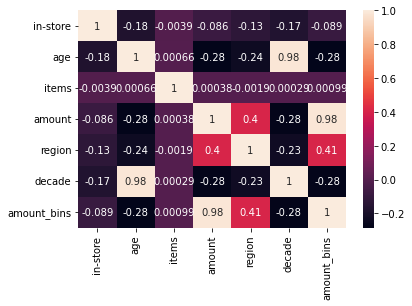

In [3]:
corr_mat = data.corr()
sns.heatmap(corr_mat, xticklabels=corr_mat.columns, yticklabels=corr_mat.columns, annot=True)

The heatmap shows that the region and amount columns have a correlation of 40%. The other correlations are pretty low. while this is not promising for the questions that Blackwell's staff have asked, it does not mean that an algorithm cannot predict them.

C:\Users\jryba\AppData\Local\Temp\ipykernel_49320\613817383.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)


Text(0, 0.5, 'Region')

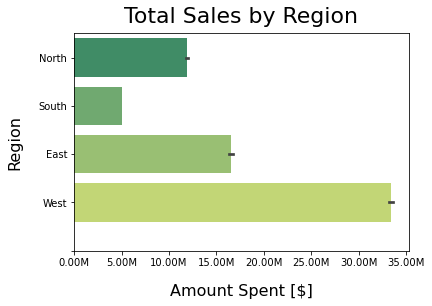

In [5]:
ax = sns.barplot(data=data, x='amount', y='region', palette='summer', 
                 estimator=sum, orient='h')
xlabels = ['{:,.2f}'.format(x) + 'M' for x in ax.get_xticks()/1000000]
ax.set_xticklabels(xlabels)
plt.title("Total Sales by Region", y=1.02, fontsize=22)
plt.yticks([0,1,2,3,4],['North','South','East','West',''])
plt.xlabel("Amount Spent [$]", labelpad=16, fontsize=16)
plt.ylabel("Region", labelpad=16, fontsize=16)

This graph shows the total amount earned before taxes and other deductions, sorted by region. The West has the highest spending by far, and the South the least. I would recommend to Blackwell to implement marketing in the North, South, and East regions to increase sales.

Text(0, 0.5, 'Region')

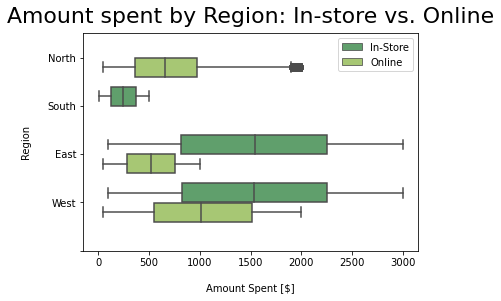

In [6]:
#Visualize the ranges for each region, separating the in-store and online data
ax = sns.boxplot(x="amount", y="region", hue='in-store', data=data, orient='h',
                 palette='summer')
plt.title("Amount spent by Region: In-store vs. Online", y=1.02, fontsize=22)
plt.legend(['In-Store','Online'])
plt.yticks([0,1,2,3,4],['North','South','East','West',''])
plt.xlabel("Amount Spent [$]", labelpad=16)
plt.ylabel("Region", labelpad=16)

As shown in the graph above, there is an immediate concern with the sales in the north and south regions. In the North, there are no in-store purchases, while no online purchases took place in the South. There is either some data missing or these are potential avenues Blackwell could take to improve sales. Either way, this will make it easier for an algorithm to determine whether a purchase was made in-store.

Text(0, 0.5, 'Region')

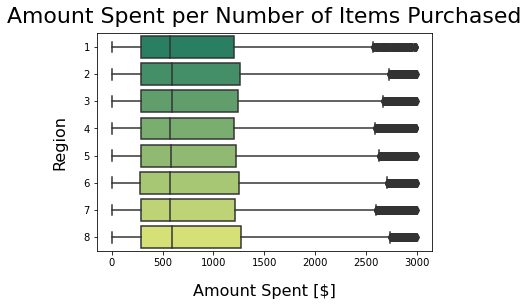

In [7]:
#Plot the items purchased vs amount spent
ax = sns.boxplot(x="amount", y="items", orient='h', data=data, palette="summer")
plt.title("Amount Spent per Number of Items Purchased", y=1.02, fontsize=22)
plt.xlabel("Amount Spent [$]", labelpad=16, fontsize=16)
plt.ylabel("Region", labelpad=16, fontsize=16)

The average customer is only willing to spend around $550 no matter how many items they bought. They are more concerned about the money spent than the number of items. If Blackwell wants to get more products off the shelf, they should offer more sales such as buy one get one free.

## Machine Learning

### Predicting Amount

Testing to see if I can predict the amount a customer spent using the other demographics. In order to get a more accurate algorithm, I sorted the amount values into bins of $500 and used a classification algorithm.

In [8]:
X = data.iloc[:,~data.columns.isin(['amount','amount_bins'])]
y = data['amount_bins']

algos_class = []
algos_class.append(('Random Forest Classifier', RandomForestClassifier()))
algos_class.append(('Decision Tree Classifier', DecisionTreeClassifier()))
algos_class.append(('Gradient Boosting Classifier', GradientBoostingClassifier()))

results = []
names = []
for name, model in algos_class:
    result = cross_val_score(model, X, y, cv=3, scoring='accuracy')
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Classifier 0.4806886964060682
Decision Tree Classifier 0.4803260841843118
Gradient Boosting Classifier 0.486440176475718


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)
algo = GradientBoostingClassifier()
model = algo.fit(X_train,y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       500.0       0.91      0.58      0.71     11014
      1000.0       0.39      0.70      0.50      5819
      1500.0       0.20      0.23      0.22      2560
      2000.0       0.19      0.17      0.18      2592
      2500.0       0.17      0.13      0.15      1002
      3000.0       0.16      0.09      0.12      1007

    accuracy                           0.49     23994
   macro avg       0.34      0.32      0.31     23994
weighted avg       0.57      0.49      0.50     23994



In [10]:
model = GradientBoostingClassifier()
print(cross_val_score(model, X, y, cv=5)) 

[0.48980995 0.48605901 0.48243311 0.48837209 0.48596436]


The Gradient Boosting Classifier did the best out of the three. With the information available, the algorithm was only able to predict the amount spent 49% of the time, even with discretized bins. Less than a coin flip!

#### Regression

As this was my first crack at machine learning, I did not attempt a regression model at the time. However, coming back to it later I felt that the predictor for amount would be a good opportunity to use one.

In [11]:
X = data.iloc[:,~data.columns.isin(['amount','amount_bins'])]
y = data['amount']

algosclass = []
algosclass.append(('Random Forest Regressor',RandomForestRegressor()))
algosclass.append(('Linear Regression',LinearRegression()))
algosclass.append(('Support Vector Regression',SVR()))

results = []
names = []
for name, model in algosclass:
    result = cross_val_score(model, X,y, cv=3, scoring='r2')
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Regressor 0.423003806841501
Linear Regression 0.2051540744291657
Support Vector Regression 0.010322147459722264


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)
algo = RandomForestRegressor(n_estimators=200)
model = algo.fit(X_train,y_train)
preds = model.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, preds))
print('r2 Score:', metrics.r2_score(y_test, preds))

Mean Absolute Error: 404.0340688875155
r2 Score: 0.4249583785316925


The Random Forest Regressor was the best, and still only .436 r2 score.

### Predicting Age

Blackwell's staff asked me if we could predict the age of a customer, specifically using the region as an independent variable.

Once again, in order to make a more accurate classification algorithm I sorted the age values into bins based on decade of life. 

In [13]:
X = data.iloc[:,~data.columns.isin(['age','decade'])]
y = data['decade']

algos_class = []
algos_class.append(('Random Forest Classifier', RandomForestClassifier()))
algos_class.append(('Decision Tree Classifier', DecisionTreeClassifier()))
algos_class.append(('Gradient Boosting Classifier', GradientBoostingClassifier()))

results = []
names = []
for name, model in algos_class:
    result = cross_val_score(model, X, y, cv=3, scoring='accuracy')
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Classifier 0.19513871209465594
Decision Tree Classifier 0.19561381211426868
Gradient Boosting Classifier 0.22039535212960373


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)
algo = GradientBoostingClassifier()
model = algo.fit(X_train,y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

        10.0       0.07      0.00      0.00       628
        20.0       0.24      0.33      0.28      3961
        30.0       0.21      0.27      0.24      5235
        40.0       0.22      0.31      0.26      5326
        50.0       0.21      0.16      0.18      4283
        60.0       0.17      0.04      0.07      2598
        70.0       0.18      0.09      0.12      1439
        80.0       0.07      0.00      0.01       524

    accuracy                           0.22     23994
   macro avg       0.17      0.15      0.15     23994
weighted avg       0.21      0.22      0.20     23994



In [15]:
model = GradientBoostingClassifier()
print(cross_val_score(model, X, y, cv=5)) 

[0.21780445 0.21649162 0.217992   0.21780445 0.22056893]


Even with the Gradient Boosting Classifier, it was only able to predict the age with a 22% accuracy.

### Predicting Region

The region category is already separated into just four possible answers, a classification algorithm may be able to predict it with some accuracy.

In [16]:
X = data.iloc[:,~data.columns.isin(['region'])]
y = data['region']

algos_class = []
algos_class.append(('Random Forest Classifier', RandomForestClassifier()))
algos_class.append(('Decision Tree Classifier', DecisionTreeClassifier()))
algos_class.append(('Gradient Boosting Classifier', GradientBoostingClassifier()))

results = []
names = []
for name, model in algos_class:
    result = cross_val_score(model, X, y, cv=3, scoring='accuracy')
    names.append(name)
    results.append(result)
    
for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Classifier 0.5807023800100218
Decision Tree Classifier 0.5622975814098692
Gradient Boosting Classifier 0.643281380474906


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)
algo = GradientBoostingClassifier()
model = algo.fit(X_train,y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.40      0.52      0.45      4838
           2       0.90      1.00      0.95      5979
           3       0.53      0.23      0.32      5391
           4       0.65      0.73      0.69      7786

    accuracy                           0.64     23994
   macro avg       0.62      0.62      0.60     23994
weighted avg       0.63      0.64      0.62     23994



In [18]:
model = GradientBoostingClassifier()
print(cross_val_score(model, X, y, cv=5)) 

[0.6447862  0.64222306 0.64003501 0.64553638 0.64432635]


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 500)
algo = DecisionTreeClassifier(max_depth=4, class_weight='balanced')
model = algo.fit(X_train,y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.41      0.54      0.46      4791
           2       0.90      1.00      0.95      6036
           3       0.53      0.22      0.31      5334
           4       0.66      0.73      0.69      7833

    accuracy                           0.65     23994
   macro avg       0.62      0.62      0.60     23994
weighted avg       0.64      0.65      0.62     23994



In [20]:
model = DecisionTreeClassifier(max_depth=4, class_weight='balanced')
print(cross_val_score(model, X, y, cv=5)) 

[0.64384846 0.64209802 0.63915979 0.64541135 0.64582682]


Even though the gradient boosting classifier was the best initially, I was able to get the Decision Tree Classifier to match it by tuning the parameters. Still, the accuracy was only 64%. Better than a coin flip but not great.

### Predicting In-Store or Online Purchases

This is the one that is most likely to work. It is a binary category so it has the fewest amount of possible choices. Blackwell asked if the algorithm could predict where the purchase was made based on age.

In [21]:
X = data.iloc[:,~data.columns.isin(['in-store'])]
y = data['in-store']

algos_class = []
algos_class.append(('Random Forest Classifier', RandomForestClassifier()))
algos_class.append(('Decision Tree Classifier', DecisionTreeClassifier()))
algos_class.append(('Gradient Boosting Classifier', GradientBoostingClassifier()))

results = []
names = []
for name, model in algos_class:
    result = cross_val_score(model, X, y, cv=3, scoring='accuracy')
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Classifier 0.8587504316343161
Decision Tree Classifier 0.8459845596456693
Gradient Boosting Classifier 0.8873454123499366


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 500)
algo = GradientBoostingClassifier(max_depth=3, n_estimators=200)
model = algo.fit(X_train,y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.78      0.87     12055
           1       0.82      0.99      0.90     11939

    accuracy                           0.89     23994
   macro avg       0.90      0.89      0.88     23994
weighted avg       0.90      0.89      0.88     23994



In [23]:
model = GradientBoostingClassifier(max_depth=3, n_estimators=200)
print(cross_val_score(model, X, y, cv=5)) 

[0.88884721 0.88484621 0.88928482 0.8867842  0.88565177]


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 500)
algo = DecisionTreeClassifier(max_depth=3, class_weight='balanced')
model = algo.fit(X_train,y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80     12055
           1       0.75      1.00      0.86     11939

    accuracy                           0.83     23994
   macro avg       0.87      0.83      0.83     23994
weighted avg       0.88      0.83      0.83     23994



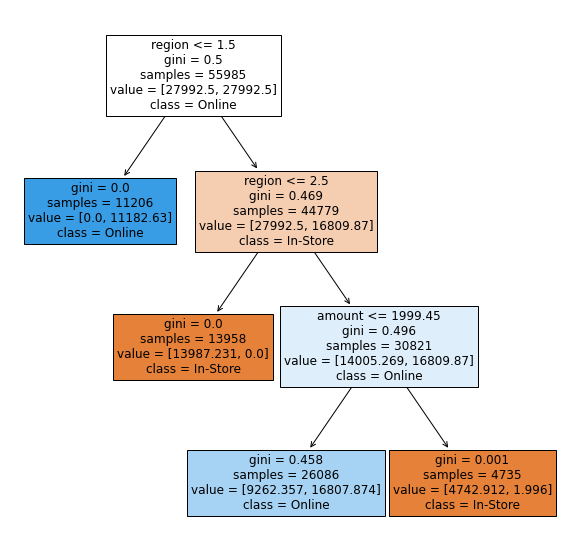

In [25]:
fig = plt.figure(figsize=(10,10))
tree = plot_tree(model, feature_names=X.columns,class_names=['In-Store', 'Online'], filled=True, fontsize=12)

I was able to predict the type of purchase with over 88% accuracy! This will be very helpful to Blackwell in the future. Though the Blackwell staff hypothesized that the customer's age would have the most influence on the in-store or online purchases, the most important variable was the region. This calls back to the graph earlier, where there were no online purchases made in the South or in-store purchases in the North.

## Conclusion

The West region did the best in sales revenue while the South did not do so well. Notably, there were no online purchases in the South or in-store purchases in the North. I would recommend exploring why this is and allowing customers to make both types of purchases in all regions. There was also a constant amount spent no matter the number of items the customer purchased. One course of action is to provide sales to draw customers in and encourage them to spend more money.

The algorithms had varying results predicting the customer demographics. It was not able to accurately predict a customer's age or how much they spent. It was able to predict the region the transaction took place in with 64% accuracy and whether it was in-store or online accurately at 88%. 